# 국회의원 명부_고유번호 크롤링

In [24]:
import requests
from bs4 import BeautifulSoup

In [25]:
url = 'http://www.assembly.go.kr/assm/memact/congressman/memCond/memCondListAjax.do'
# 내가 보는 것은 위의 url인데, 코드에서는 아래처럼 되어 있음
#http://www.assembly.go.kr/assm/memact/congressman/memCond/memCondListAjax.do

headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36' }
params = {'currentPage': 1, 'rowPerPage': 300}
html = requests.get(url, params = params, headers = headers).text # 소스코드를 불러옴, params의 역할은 아직 모르겠음...

In [26]:
soup = BeautifulSoup(html, 'lxml') # 파이썬 내장 파써인 html.parser보다 속도가 훨씬 빠름

In [27]:
names = []
tag_list = []

for idx, tag in enumerate(soup.select('a[href*=jsMemPop]'), 1):
#    print(idx, tag)
#    print('[{}] {}' .format(idx, tag))
    tag_list.append(tag.get('href')[-9:-2])
    names.append(tag.text)
# enumerate는 앞에 순서번호를 자동으로 붙여주는 형식을 만들어줌
# idx는 enumerate가 제공하는 index이고, 그것을 시작하는 번호를 지정할 수 있음

In [28]:
print(len(tag_list))
# tag_list

299


In [29]:
print(len(names))
# names

299


# 국회의원 상세정보 추가

- http://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9770933
- 국회의원별 정보

## 정당 정보

In [30]:
from urllib.request import urlopen
import time

basic_url = 'http://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd='

# 그냥 soup.select를 하면, 메인 페이지 내에 있는 것을 검색함
# 상세페이지로 BeautiflSoup을 통해서 다시 soup_each를 만들어줘야 함
# 그리고 BeautifulSoup은 브라우저(html client)가 아니므로, 
# reqeust나 urllib을 통해서 읽어들인 후에 넣어줘야 함

# soup_each.select('dl.pro_detail > dd')[0].text

In [31]:
import pandas as pd
columns = {'name': names, 
           'tag_list': tag_list, 
          }
total_df = pd.DataFrame(columns, index = tag_list)

In [32]:
# 정당
import time
from tqdm import tqdm_notebook

party = []

start_time = time.time() 

for i in tqdm_notebook(range(1, 30), desc = '정당리스트'):
    url_each = basic_url + total_df['tag_list'][i]
    html = requests.get(url_each).text 
    soup_each = BeautifulSoup(html, 'lxml')
    # soup_each = BeautifulSoup(urlopen(url_each), 'lxml')
    # Urllib은 약 30% 정도 속도가 느림

    # print(i, url_each)
    party.append(soup_each.select('dl.pro_detail > dd')[0].text)
    # print(i, party)
    
gap = time.time() - start_time
print(f"{gap//60:.0f}분 {gap%60:.0f}초")
print('{}개의 정당 목록을 정리했습니다.' .format(len(party)))


0분 19초
29개의 정당 목록을 정리했습니다.


In [33]:
column_names = soup_each.select('dl.pro_detail > dt')
len(column_names)
column_names

[<dt>정당</dt>,
 <dt>선거구</dt>,
 <dt>소속위원회</dt>,
 <dt>당선횟수</dt>,
 <dt>사무실전화</dt>,
 <dt>홈페이지</dt>,
 <dt>이메일</dt>,
 <dt>보좌관</dt>,
 <dt>비서관</dt>,
 <dt>비서</dt>,
 <dt>취미, 특기</dt>]

In [37]:
num = 0
dt_list = []

for d in tqdm_notebook(column_names, desc = "진행률"):
    dt = d.text
#    print(dt, "시작")
    start_time = time.time()     
    dt_sublist = []
    
    for i in tqdm_notebook(range(299), desc = dt):
        url_each = basic_url + total_df['tag_list'][i]
#        print(url_each)
        html = requests.get(url_each).text 
        soup_each = BeautifulSoup(html, 'lxml')
        dt_sublist.append(soup_each.select('dl.pro_detail > dd')[num].text)
#        print(dt_sublist)

    dt_list.append(dt_sublist)
    gap = time.time() - start_time
    num = num + 1
#    print(dt_list)
#    print(f"{dt} 마감 : {gap//60:.0f}분 {gap%60:.1f}초")
    
# dt_list

# 국회의원 정보 통합

In [394]:
import pandas as pd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
plt.rc('font', family='Malgun Gothic')
# 그래프 내 한글 보여주도록 하는 부분

%matplotlib inline

In [22]:
url_list = []

for i in range(299):
    url_each = basic_url + total_df['tag_list'][i]
    url_list.append(url_each)

url_list

NameError: name 'total_df' is not defined

In [276]:
columns = {'name': names, 
           'tag_list': tag_list, 
           '정당': dt_list[0], 
           '선거구': dt_list[1], 
           '소속위원회': dt_list[2],
           '당선횟수': dt_list[3],
           '사무실전화': dt_list[4],
           '홈페이지': dt_list[5],
           '이메일': dt_list[6],
           '보좌관': dt_list[7],
           '비서관': dt_list[8],
           '비서': dt_list[9],
           '취미특기': dt_list[10],
           '링크': url_list
          }
total_df2 = pd.DataFrame(columns, index = tag_list)
total_df2 = total_df2.replace('\n','',regex = True)
total_df2 = total_df2.replace('\t','',regex = True)
total_df2 = total_df2.replace('\r','',regex = True)
total_df2 = total_df2.replace(" ",'',regex = True)
print(total_df2.shape)
total_df2.head()

(299, 14)


name tag_list      정당             선거구            소속위원회  \
9770276  강길부  9770276     무소속           울산울주군  산업통상자원중소벤처기업위원회   
9770933  강병원  9770933  더불어민주당          서울은평구을          기획재정위원회   
9771036  강석진  9771036   자유한국당  경남산청군함양군거창군합천군    농림축산식품해양수산위원회   
9770512  강석호  9770512   자유한국당  경북영양군영덕군봉화군울진군          외교통일위원회   
9770279  강창일  9770279  더불어민주당          제주제주시갑          행정안전위원회   

                        당선횟수        사무실전화                            홈페이지  \
9770276  4선(17대,18대,19대,20대)  02-788-2708                                   
9770933              초선(20대)  02-784-1422  http://blog.naver.com/kangbw89   
9771036              초선(20대)  02-784-1460                                   
9770512      3선(18대,19대,20대)  02-784-2376                http://kangsh.kr   
9770279  4선(17대,18대,19대,20대)  02-784-6084           http://www.kangci.net   

                             이메일          보좌관      비서관                   비서  \
9770276  uljukang@assembly.go.kr      윤지현,정재원  이수철,차상윤      고길주,김변호,장경희,박금숙   
9770933       kangbw89@gmail.com  김재홍,김영근,장용득  이여진,김영기  김형근,정연우,권민준,김민재,안신영   
9771036       ksjv7900@naver.com      김완철,오석환  서일교,신우성      김준형,신용욱,용선주,정진남   
9770512          kangsh@na.go.kr      임종석,홍성범  김동우,정성한      한승룡,서재광,조하나,박민지   
9770279        kang809@gmail.com      강신혁,김행준  김명언,유동현  배경민,정민희,하소라,이진욱,신윤정   

          취미특기                                                 링크  
9770276         http://www.assembly.go.kr/assm/memPop/memPopup...  
9770933  등산,독서  http://www.assembly.go.kr/assm/memPop/memPopup...  
9771036         http://www.assembly.go.kr/assm/memPop/memPopup...  
9770512    스포츠  http://www.assembly.go.kr/assm/memPop/memPopup...  
9770279     바둑  http://www.assembly.go.kr/assm/memPop/memPopup...

In [278]:
total_df2.to_csv('국회의원명단.csv', encoding = 'cp949') 

#한글이 깨지는 것을 막기 위해서 인코딩 추가

#utf-8, cp949
#현재 python은 utf-8 표준화 되어있다.
#cp949는 windows 생성된 파일이다. 

# 공약이행률 미공개자 분석

In [307]:
url2 = 'http://manifesto.or.kr/?p=5504'
headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36' }
html2 = requests.get(url2, headers = headers).text
soup2 = BeautifulSoup(html2, 'lxml')

no_keep = soup2.select('p')[5]
no_keep = str(no_keep)

no_keep.count(',')

27

In [308]:
no_keep

'<p>유승희 (서울 성북구갑), 정양석 (강북구갑), 인재근 (도봉구갑), 김선동 (도봉구을),<br/>\n김영호 (서대문구을), 이종구 (강남구갑), 김무성 (부산 중구영도구), 배덕광 (해운대구을),<br/>\n조원진 (대구 달서구병), 천정배 (광주 서구을), 이은권 (대전 중구), 김종훈 (울산 동구),<br/>\n이언주 (경기 광명시을), 표창원 (용인시정), 홍철호 (김포시을), 김진태 (강원 춘천시),<br/>\n김기선 (원주시갑), 권성동 (강릉시), 박덕흠 (충북 보은군옥천군영동군괴산군),<br/>\n정진석 (충남 공주시부여군청양군), 이용호 (전북 남원시임실군순창군), 박지원 (전남 목포시),<br/>\n백승주 (경북 구미시갑), 장석춘 (구미시을), 최교일 (영주시문경시예천군),<br/>\n노회찬 (경남 창원시성산구), 여상규 (사천시남해군하동군), 서형수 (양산시을)</p>'

In [309]:
no_keep = no_keep.replace('<p>', '')
no_keep = no_keep.replace('<br/>\n', '')
no_keep = no_keep.replace('</p>', '')
no_keep

'유승희 (서울 성북구갑), 정양석 (강북구갑), 인재근 (도봉구갑), 김선동 (도봉구을),김영호 (서대문구을), 이종구 (강남구갑), 김무성 (부산 중구영도구), 배덕광 (해운대구을),조원진 (대구 달서구병), 천정배 (광주 서구을), 이은권 (대전 중구), 김종훈 (울산 동구),이언주 (경기 광명시을), 표창원 (용인시정), 홍철호 (김포시을), 김진태 (강원 춘천시),김기선 (원주시갑), 권성동 (강릉시), 박덕흠 (충북 보은군옥천군영동군괴산군),정진석 (충남 공주시부여군청양군), 이용호 (전북 남원시임실군순창군), 박지원 (전남 목포시),백승주 (경북 구미시갑), 장석춘 (구미시을), 최교일 (영주시문경시예천군),노회찬 (경남 창원시성산구), 여상규 (사천시남해군하동군), 서형수 (양산시을)'

In [310]:
no_keep = no_keep.split(',')

In [312]:
no_keep
len(no_keep)

28

In [313]:
no_keep

['유승희 (서울 성북구갑)',
 ' 정양석 (강북구갑)',
 ' 인재근 (도봉구갑)',
 ' 김선동 (도봉구을)',
 '김영호 (서대문구을)',
 ' 이종구 (강남구갑)',
 ' 김무성 (부산 중구영도구)',
 ' 배덕광 (해운대구을)',
 '조원진 (대구 달서구병)',
 ' 천정배 (광주 서구을)',
 ' 이은권 (대전 중구)',
 ' 김종훈 (울산 동구)',
 '이언주 (경기 광명시을)',
 ' 표창원 (용인시정)',
 ' 홍철호 (김포시을)',
 ' 김진태 (강원 춘천시)',
 '김기선 (원주시갑)',
 ' 권성동 (강릉시)',
 ' 박덕흠 (충북 보은군옥천군영동군괴산군)',
 '정진석 (충남 공주시부여군청양군)',
 ' 이용호 (전북 남원시임실군순창군)',
 ' 박지원 (전남 목포시)',
 '백승주 (경북 구미시갑)',
 ' 장석춘 (구미시을)',
 ' 최교일 (영주시문경시예천군)',
 '노회찬 (경남 창원시성산구)',
 ' 여상규 (사천시남해군하동군)',
 ' 서형수 (양산시을)']

In [330]:
lists = []

for i in range(28):
    list = no_keep[i].split(' (')
    lists.append(list)

print(lists)

[['유승희', '서울 성북구갑)'], [' 정양석', '강북구갑)'], [' 인재근', '도봉구갑)'], [' 김선동', '도봉구을)'], ['김영호', '서대문구을)'], [' 이종구', '강남구갑)'], [' 김무성', '부산 중구영도구)'], [' 배덕광', '해운대구을)'], ['조원진', '대구 달서구병)'], [' 천정배', '광주 서구을)'], [' 이은권', '대전 중구)'], [' 김종훈', '울산 동구)'], ['이언주', '경기 광명시을)'], [' 표창원', '용인시정)'], [' 홍철호', '김포시을)'], [' 김진태', '강원 춘천시)'], ['김기선', '원주시갑)'], [' 권성동', '강릉시)'], [' 박덕흠', '충북 보은군옥천군영동군괴산군)'], ['정진석', '충남 공주시부여군청양군)'], [' 이용호', '전북 남원시임실군순창군)'], [' 박지원', '전남 목포시)'], ['백승주', '경북 구미시갑)'], [' 장석춘', '구미시을)'], [' 최교일', '영주시문경시예천군)'], ['노회찬', '경남 창원시성산구)'], [' 여상규', '사천시남해군하동군)'], [' 서형수', '양산시을)']]


In [333]:
lists = pd.DataFrame(lists) #, columns = [['이름', '지역구']])
# lists.columns['이름', '지역구']
lists.head()

lists[0]

0      유승희
1      정양석
2      인재근
3      김선동
4      김영호
5      이종구
6      김무성
7      배덕광
8      조원진
9      천정배
10     이은권
11     김종훈
12     이언주
13     표창원
14     홍철호
15     김진태
16     김기선
17     권성동
18     박덕흠
19     정진석
20     이용호
21     박지원
22     백승주
23     장석춘
24     최교일
25     노회찬
26     여상규
27     서형수
Name: 0, dtype: object

In [372]:
import numpy as np
no_keep_list = np.array(lists[0][:])

In [373]:
no_keep_list

array(['유승희', ' 정양석', ' 인재근', ' 김선동', '김영호', ' 이종구', ' 김무성', ' 배덕광',
       '조원진', ' 천정배', ' 이은권', ' 김종훈', '이언주', ' 표창원', ' 홍철호', ' 김진태',
       '김기선', ' 권성동', ' 박덕흠', '정진석', ' 이용호', ' 박지원', '백승주', ' 장석춘',
       ' 최교일', '노회찬', ' 여상규', ' 서형수'], dtype=object)

In [387]:
for i in range(len(no_keep_list)):
#    print(i, no_keep_list[i])
    no_keep_list[i] = no_keep_list[i].strip()
#    print(new)
#    print(new_list)

no_keep_list

array(['유승희', '정양석', '인재근', '김선동', '김영호', '이종구', '김무성', '배덕광', '조원진',
       '천정배', '이은권', '김종훈', '이언주', '표창원', '홍철호', '김진태', '김기선', '권성동',
       '박덕흠', '정진석', '이용호', '박지원', '백승주', '장석춘', '최교일', '노회찬', '여상규',
       '서형수'], dtype=object)

In [353]:
lists

0                 1
0    유승희          서울 성북구갑)
1    정양석             강북구갑)
2    인재근             도봉구갑)
3    김선동             도봉구을)
4    김영호            서대문구을)
5    이종구             강남구갑)
6    김무성         부산 중구영도구)
7    배덕광            해운대구을)
8    조원진          대구 달서구병)
9    천정배           광주 서구을)
10   이은권            대전 중구)
11   김종훈            울산 동구)
12   이언주          경기 광명시을)
13   표창원             용인시정)
14   홍철호             김포시을)
15   김진태           강원 춘천시)
16   김기선             원주시갑)
17   권성동              강릉시)
18   박덕흠  충북 보은군옥천군영동군괴산군)
19   정진석     충남 공주시부여군청양군)
20   이용호     전북 남원시임실군순창군)
21   박지원           전남 목포시)
22   백승주          경북 구미시갑)
23   장석춘             구미시을)
24   최교일        영주시문경시예천군)
25   노회찬        경남 창원시성산구)
26   여상규        사천시남해군하동군)
27   서형수             양산시을)

In [364]:
if '유승희' in no_keep_list :
    print("있다")
else:
    print("없다")

있다


In [388]:
for i in range(299):
    name = total_df2["name"][i]
    if name in no_keep_list:
        total_df2["공약미이행"][i] = "fail"
        print(name)
    else:
        total_df2["공약미이행"][i] = "success"

권성동
김기선
김무성
김선동
김영호
김종훈
김진태
박덕흠
박지원
백승주
서형수
여상규
유승희
이언주
이용호
이은권
이종구
인재근
장석춘
정양석
정진석
조원진
천정배
최교일
표창원
홍철호


In [389]:
total_df2.loc[total_df2["공약미이행"] == "fail"].shape

(26, 15)

In [390]:
fail_list = total_df2.loc[total_df2["공약미이행"] == "fail"]

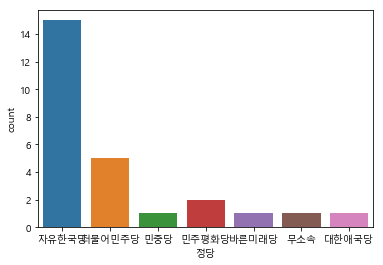

In [393]:
sns.countplot(fail_list["정당"])

# 국회의원 DB 분석

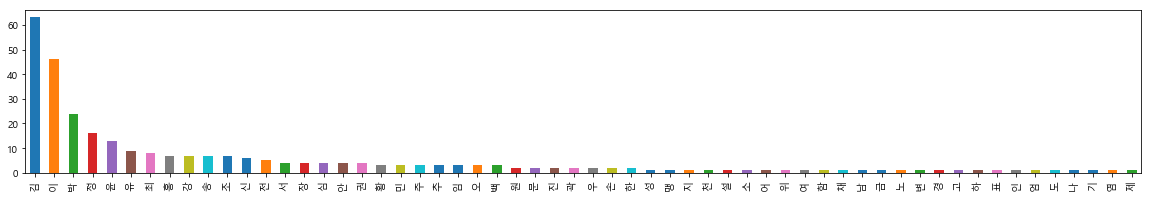

In [396]:
# 국회의원 성씨 빈도 분석
series = pd.Series(names)
series.str.slice(0,1).value_counts().plot(kind = 'bar', figsize = (20, 3))